<a href="https://colab.research.google.com/github/sofiaanzolao/Parcial-2/blob/main/Parcial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parcial 2-H2 IA**

**1**. **Exploración de datos**

In [ ]:
#Importacion de datos
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
cols = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

df = pd.read_csv("/content/adult.data", names=cols, sep=",", skipinitialspace=True)
df_test = pd.read_csv("/content/adult.test", names=cols, sep=",", skipinitialspace=True, skiprows=1)
print(df.head())



   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [ ]:
#Split 50/50
from sklearn.model_selection import train_test_split


# 1) Limpieza etiquetas (adult.test trae punto final en income)
df_test["income"] = df_test["income"].str.replace(".", "", regex=False).str.strip()
df["income"] = df["income"].str.strip()

# 2) Split 50/50 del archivo de prueba (df_test) → VALID y TEST
df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=df_test["income"]
)
print("Train:", df.shape, " | Val:", df_val.shape, " | Test:", df_test.shape)

# 3) Separar X/y desde cada DataFrame
target = "income"
pos_label = ">50K"

X_train = df.drop(columns=[target]).copy()
y_train = (df[target] == pos_label).astype(int).to_numpy().reshape(-1,1)

X_val   = df_val.drop(columns=[target]).copy()
y_val   = (df_val[target] == pos_label).astype(int).to_numpy().reshape(-1,1)

X_test  = df_test.drop(columns=[target]).copy()
y_test  = (df_test[target] == pos_label).astype(int).to_numpy().reshape(-1,1)

# 4) Sanity checks
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0]   == y_val.shape[0]
assert X_test.shape[0]  == y_test.shape[0]




Train: (32561, 15)  | Val: (8141, 15)  | Test: (8140, 15)


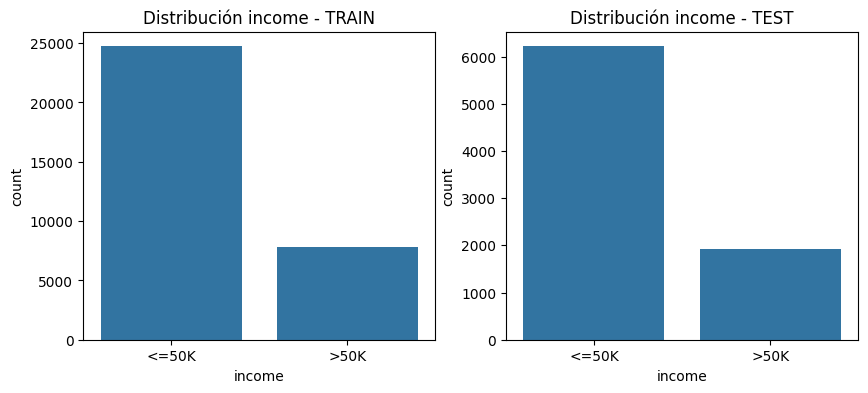

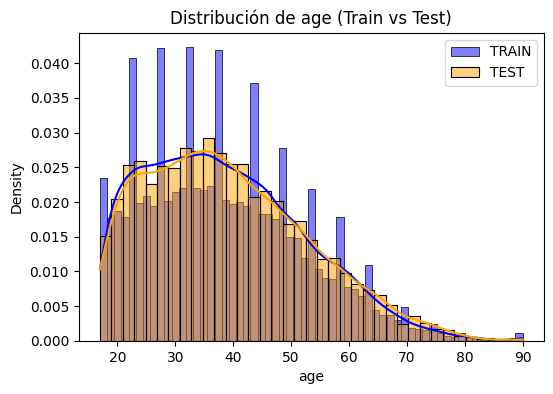

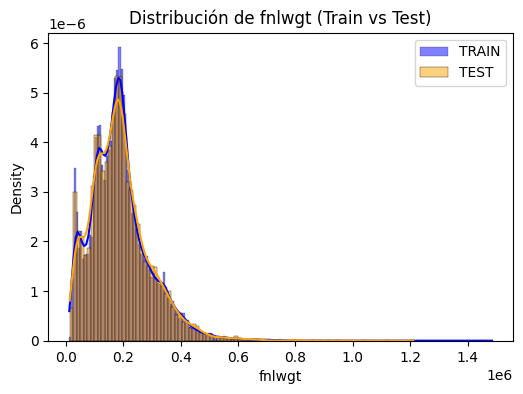

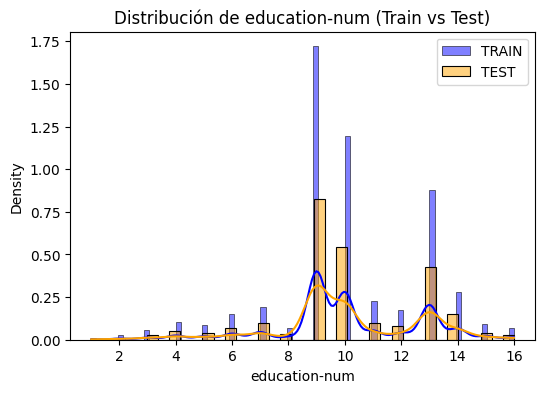

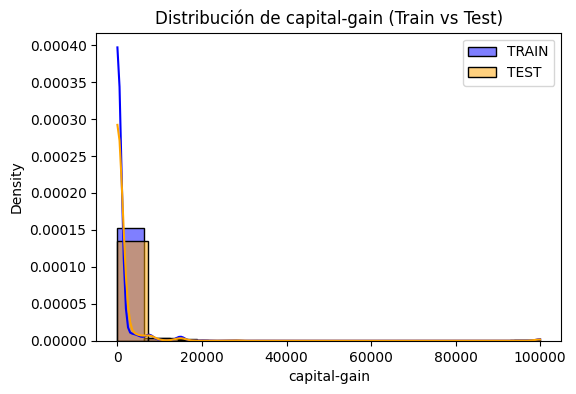

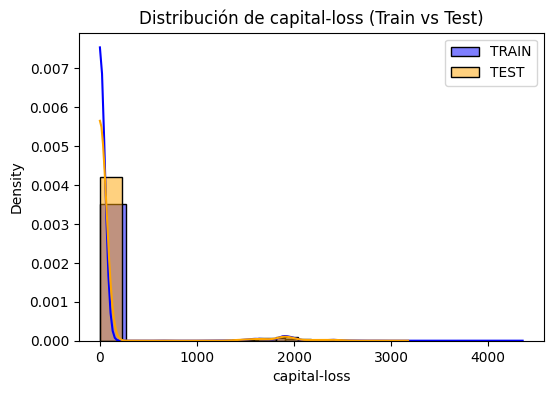

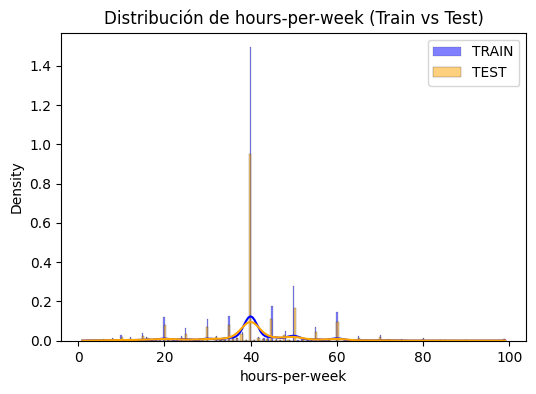

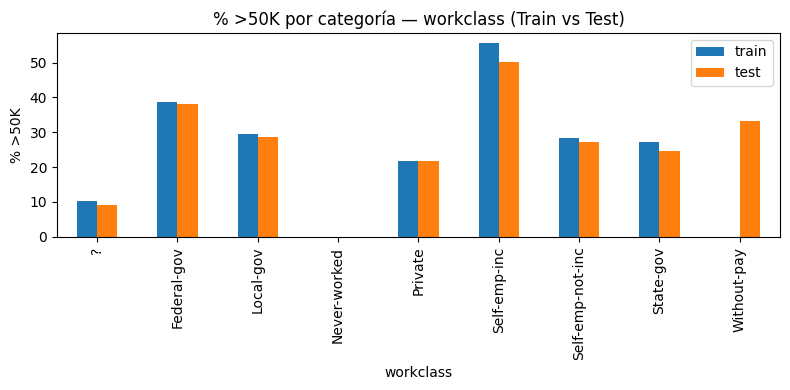

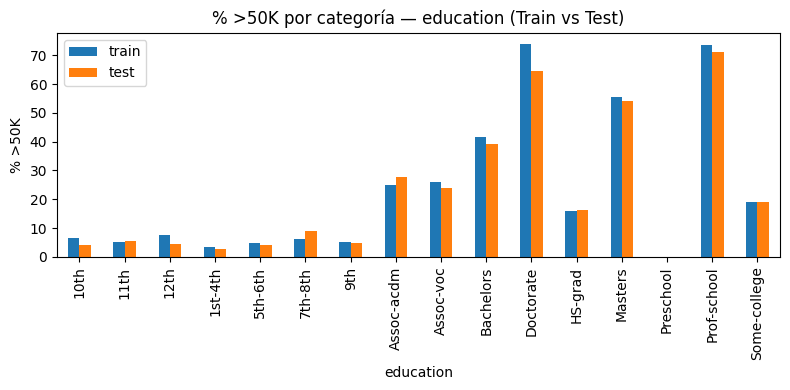

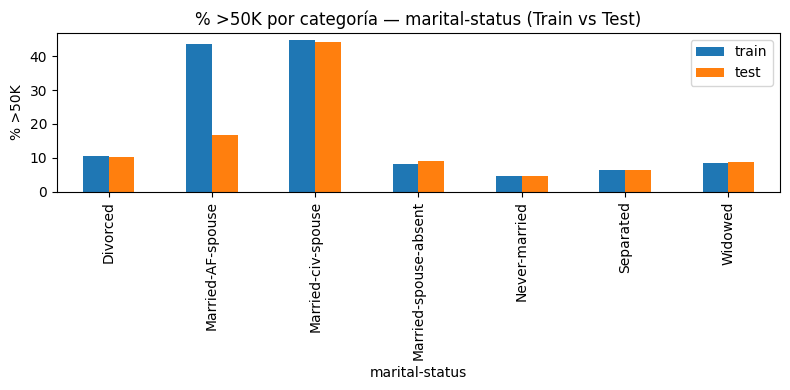

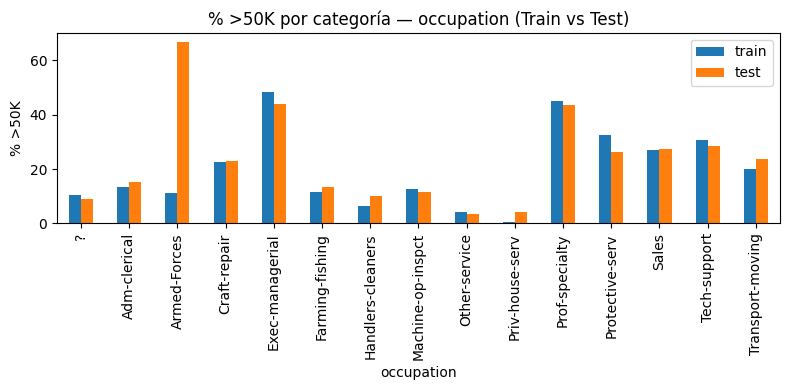

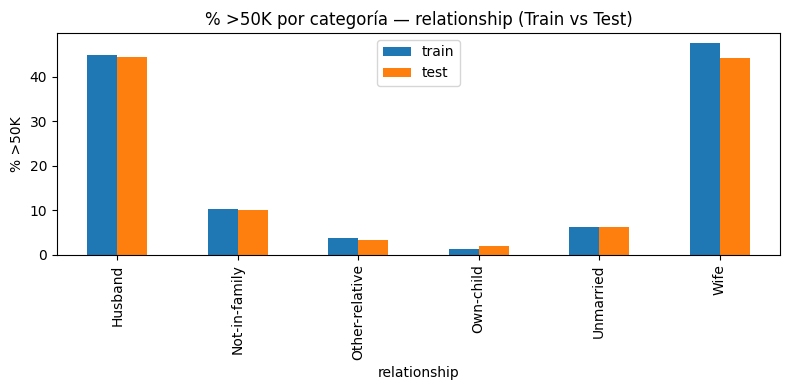

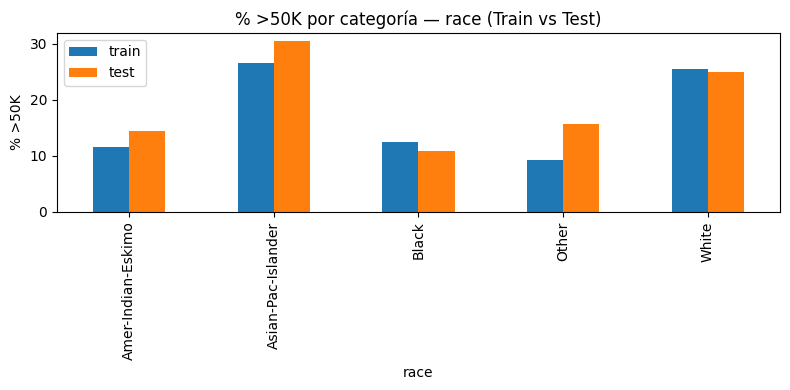

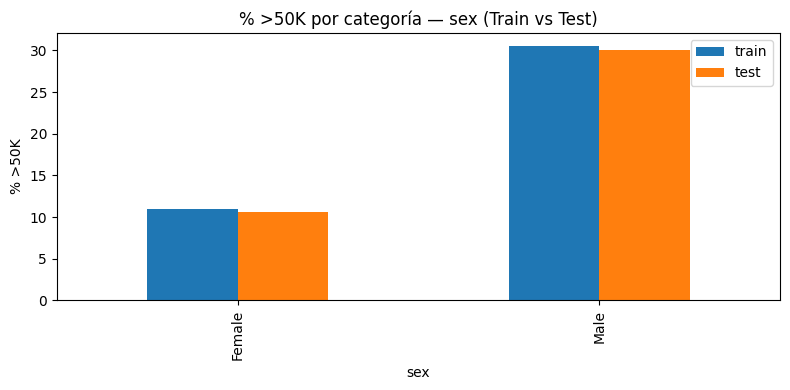

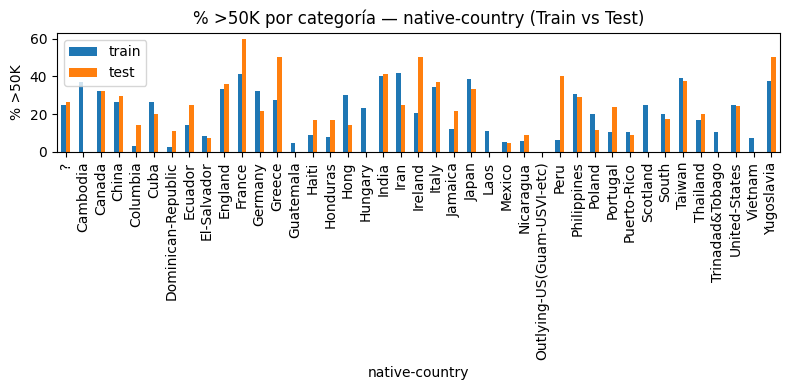

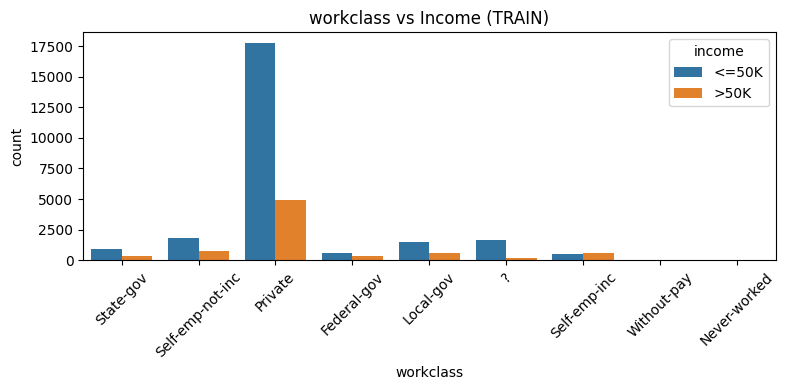

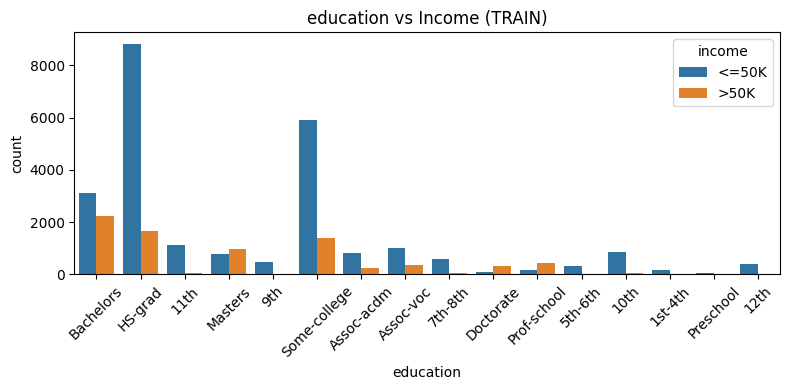

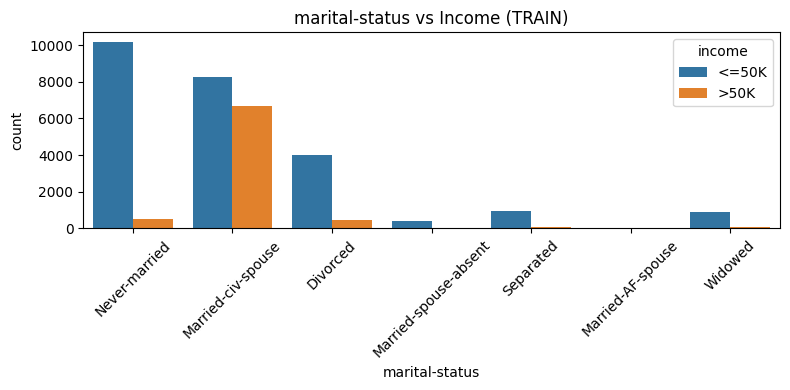

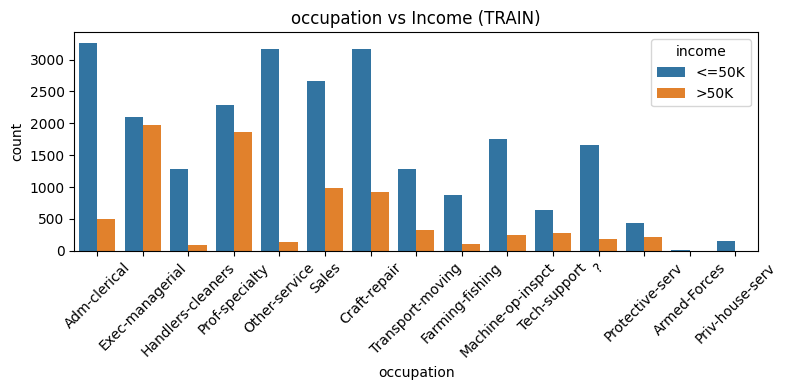

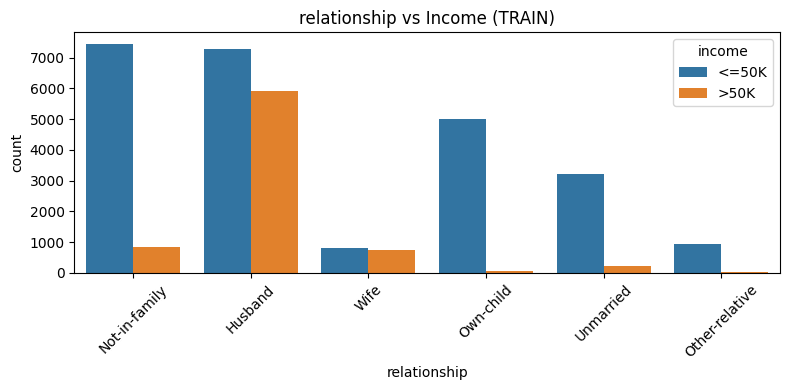

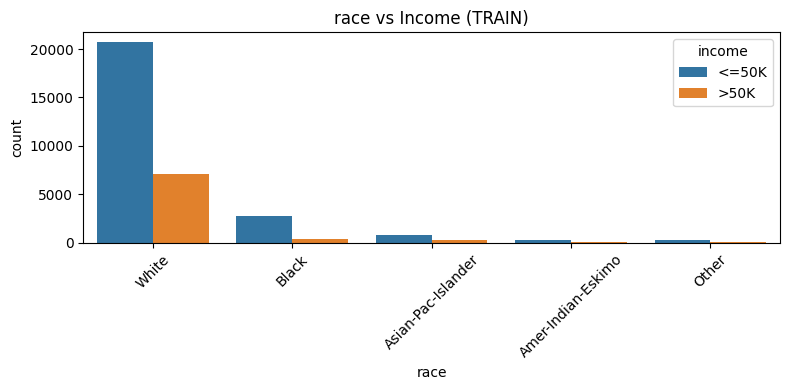

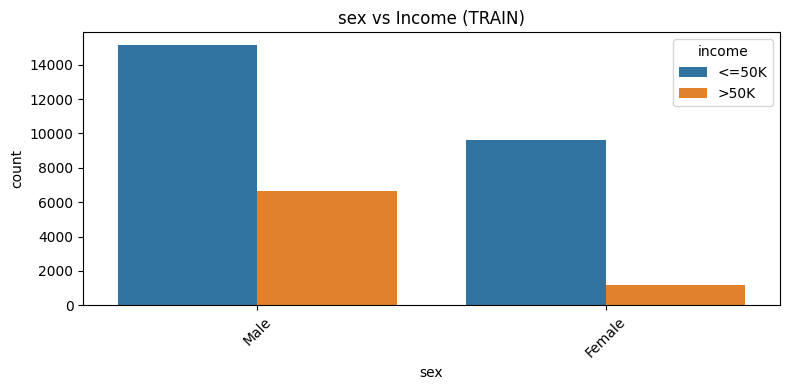

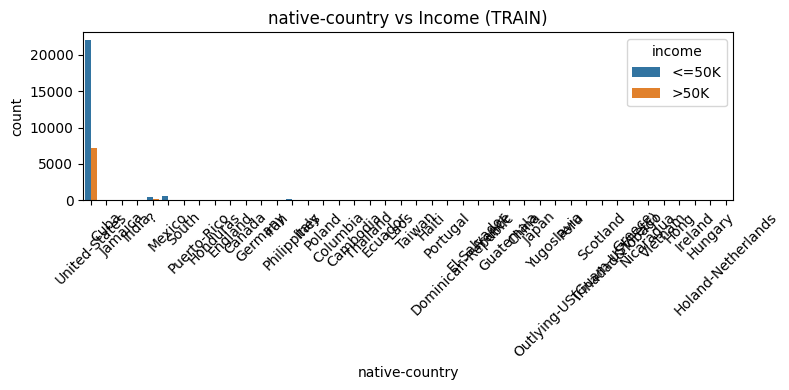

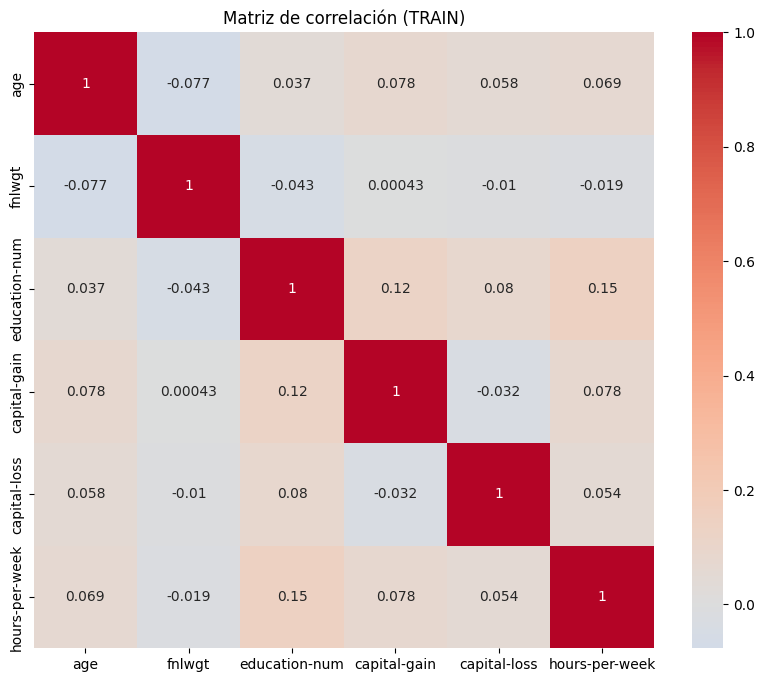

In [ ]:
#Exploratory Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Balance de clases ---
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.countplot(data=df, x="income", ax=ax[0])
ax[0].set_title("Distribución income - TRAIN")
sns.countplot(data=df_test, x="income", ax=ax[1])
ax[1].set_title("Distribución income - TEST")
plt.show()

# --- 2. Variables numéricas: histogramas comparativos ---
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], label="TRAIN", color="blue", kde=True, stat="density", alpha=0.5)
    sns.histplot(df_test[col], label="TEST", color="orange", kde=True, stat="density", alpha=0.5)
    plt.title(f"Distribución de {col} (Train vs Test)")
    plt.legend()
    plt.show()

# --- 3. Variables categóricas: proporción de income>50K ---
pos_label = ">50K"
cat_cols = df.select_dtypes(include=["object"]).drop(columns=["income"]).columns

for c in cat_cols:
    ct_train = pd.crosstab(df[c], df["income"], normalize="index")*100
    ct_test  = pd.crosstab(df_test[c], df_test["income"], normalize="index")*100

    if pos_label in ct_train.columns and pos_label in ct_test.columns:
        comp = pd.DataFrame({
            "train": ct_train[pos_label],
            "test":  ct_test[pos_label]
        }).dropna()

        comp.plot(kind="bar", figsize=(8,4))
        plt.title(f"% {pos_label} por categoría — {c} (Train vs Test)")
        plt.ylabel(f"% {pos_label}")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
# --- 5. Variables categóricas vs Income ---
cat_cols = df.select_dtypes(include='object').columns.drop('income')
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='income', data=df)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Income (TRAIN)")
    plt.tight_layout()
    plt.show()
# --- 6. Correlación entre variables numéricas ---
num_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (TRAIN)")
plt.show()


TRAIN - distribución de clases:
Clase 0: 24720 (75.92%)
Clase 1: 7841 (24.08%)

VALID - distribución de clases:
Clase 0: 6218 (76.38%)
Clase 1: 1923 (23.62%)

TEST - distribución de clases:
Clase 0: 6217 (76.38%)
Clase 1: 1923 (23.62%)


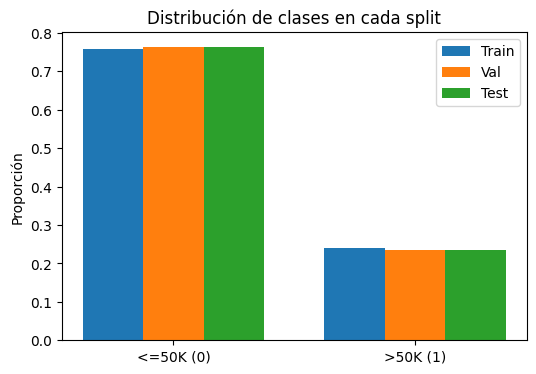

In [ ]:
#Desbalanceado o no
import numpy as np
import matplotlib.pyplot as plt

def check_balance(y, name="split"):
    uniques, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"\n{name} - distribución de clases:")
    for u, c in zip(uniques, counts):
        pct = c/total*100
        print(f"Clase {u}: {c} ({pct:.2f}%)")
    return counts / total

# Revisar train, val, test
train_dist = check_balance(y_train, "TRAIN")
val_dist   = check_balance(y_val, "VALID")
test_dist  = check_balance(y_test, "TEST")

# --- Gráfico comparativo ---
labels = ["<=50K (0)", ">50K (1)"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width, train_dist, width, label="Train")
ax.bar(x,         val_dist,   width, label="Val")
ax.bar(x + width, test_dist,  width, label="Test")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Proporción")
ax.set_title("Distribución de clases en cada split")
ax.legend()
plt.show()


In [ ]:
#Procesamiento de los datos
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ---------- 0) Limpieza previa (en todos los splits) ----------
def _strip_and_na(df_):
    df_ = df_.copy()
    # Quitar espacios a columnas object y estandarizar '?'
    for c in df_.columns:
        if df_[c].dtype == 'object':
            df_[c] = df_[c].astype(str).str.strip()
    df_.replace('?', np.nan, inplace=True)
    return df_

X_train = _strip_and_na(X_train)
X_val   = _strip_and_na(X_val)
X_test  = _strip_and_na(X_test)

# ---------- 1) Detección de columnas por dtype SOLO en TRAIN ----------
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()

# (Opcional) Forzar a numéricas algunas columnas que deberían serlo
force_numeric = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
for c in force_numeric:
    if c in X_train.columns:
        X_train[c] = pd.to_numeric(X_train[c], errors='coerce')
        X_val[c]   = pd.to_numeric(X_val[c],   errors='coerce')
        X_test[c]  = pd.to_numeric(X_test[c],  errors='coerce')
# Recalcular num/cat por si cambió algo
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# ---------- 2) Codificador con compatibilidad de versión ----------
# sklearn >=1.2 usa sparse_output; versiones previas usan sparse
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# ---------- 3) Preprocesador con imputación + escala ----------
preprocessor = ColumnTransformer(
    transformers=[
        # Numéricas: imputa mediana + escala estándar
        ("num",  Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler())
        ]), num_cols),

        # Categóricas: imputa moda + OneHot (handle_unknown=ignore)
        ("cat",  Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ],
    remainder="drop",
    n_jobs=None  # puedes poner -1 si lo soporta tu sklearn
)

# ---------- 4) Ajustar SOLO con TRAIN (evita leakage) ----------
preprocessor.fit(X_train)

# ---------- 5) Transformar (y castear a float32) ----------
X_train_proc = preprocessor.transform(X_train).astype(np.float32)
X_val_proc   = preprocessor.transform(X_val).astype(np.float32)
X_test_proc  = preprocessor.transform(X_test).astype(np.float32)

# ---------- 6) Escalar el target ----------
from sklearn.preprocessing import StandardScaler as _Std
t_scaler = _Std()
y_train_scaled = t_scaler.fit_transform(y_train)
y_val_scaled   = t_scaler.transform(y_val)
y_test_scaled  = t_scaler.transform(y_test)

# ---------- 7) Checks de sanity ----------
print("Shapes procesadas:")
print("X_train:", X_train_proc.shape, "| y_train:", y_train_scaled.shape)
print("X_val:  ", X_val_proc.shape,   "| y_val:  ", y_val_scaled.shape)
print("X_test: ", X_test_proc.shape,  "| y_test: ", y_test_scaled.shape)

Shapes procesadas:
X_train: (32561, 105) | y_train: (32561, 1)
X_val:   (8141, 105) | y_val:   (8141, 1)
X_test:  (8140, 105) | y_test:  (8140, 1)


**2. Desarrollo de algoritmos**

In [ ]:
#2.1. Modelo Baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# --- 1) Entrenar modelo baseline ---
logit = LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")
logit.fit(X_train_proc, y_train.ravel())  # ravel() para evitar warning con shape (n,1)

# --- 2) Función para métricas ---
def eval_metrics(clf, X, y, split_name="split"):
    prob = clf.predict_proba(X)[:, 1]
    pred = (prob >= 0.5).astype(int)
    acc = accuracy_score(y, pred)
    pre = precision_score(y, pred, zero_division=0)
    rec = recall_score(y, pred, zero_division=0)
    f1  = f1_score(y, pred, zero_division=0)
    auc = roc_auc_score(y, prob)
    print(f"[{split_name}] ACC={acc:.4f} | PREC={pre:.4f} | REC={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f}")
    return {"acc":acc, "prec":pre, "rec":rec, "f1":f1, "auc":auc}

# --- 3) Métricas en cada split ---
print("\n== Baseline: Logistic Regression ==")
metrics_train = eval_metrics(logit, X_train_proc, y_train, "TRAIN")
metrics_val   = eval_metrics(logit, X_val_proc,   y_val,   "VALID")
metrics_test  = eval_metrics(logit, X_test_proc,  y_test,  "TEST")

# --- 4) Reporte detallado (ejemplo en test) ---
print("\nReporte de clasificación en TEST:\n")
print(classification_report(y_test, (logit.predict_proba(X_test_proc)[:,1] >= 0.5).astype(int)))

#Dado que el dataset está desbalanceado (≈ 76/24),
#la métrica de accuracy no refleja bien el desempeño en la clase minoritaria.
#Por eso complementamos con F1, precision, recall y AUC



== Baseline: Logistic Regression ==
[TRAIN] ACC=0.8520 | PREC=0.7375 | REC=0.5984 | F1=0.6607 | AUC=0.9073
[VALID] ACC=0.8548 | PREC=0.7383 | REC=0.5970 | F1=0.6601 | AUC=0.9091
[TEST] ACC=0.8463 | PREC=0.7173 | REC=0.5767 | F1=0.6394 | AUC=0.8984

Reporte de clasificación en TEST:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6217
           1       0.72      0.58      0.64      1923

    accuracy                           0.85      8140
   macro avg       0.80      0.75      0.77      8140
weighted avg       0.84      0.85      0.84      8140



In [ ]:
#2.2. Modelo de Redes Neuronales
#a)
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Tensores
Xtr = torch.tensor(X_train_proc, dtype=torch.float32, device=device)
ytr = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32, device=device)

Xva = torch.tensor(X_val_proc,   dtype=torch.float32, device=device)
yva = torch.tensor(y_val.reshape(-1,1),   dtype=torch.float32, device=device)

Xte = torch.tensor(X_test_proc,  dtype=torch.float32, device=device)
yte = torch.tensor(y_test.reshape(-1,1),  dtype=torch.float32, device=device)

train_ds = TensorDataset(Xtr, ytr)
val_ds   = TensorDataset(Xva, yva)
test_ds  = TensorDataset(Xte, yte)



device: cpu


In [ ]:
#b)
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=[256,128], pdrop=0.3):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(pdrop)]
            prev = h
        layers += [nn.Linear(prev, 1), nn.Sigmoid()]  # salida binaria
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

criterion = nn.BCELoss()  # como en clase para binario con Sigmoid


In [ ]:
#c)
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4, mode="max"):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.bad = 0
    def step(self, metric):
        if self.best is None:
            self.best = metric
            return False
        improve = (metric > self.best + self.min_delta) if self.mode=="max" else (metric < self.best - self.min_delta)
        if improve:
            self.best = metric
            self.bad = 0
        else:
            self.bad += 1
        return self.bad >= self.patience
